In [1]:
import math
import json
import os

import numpy as np
import matplotlib.pyplot as plt

from experiment_utils import prepare_data, run_search, build_graph, logspace

In [2]:
QUERY_COUNT = 1000
ITEM_COUNT = 10 ** 5
DIMENSION = 16
GT_TOP_LEN = 100

RECALL_TOP_LEN = 5
RECALL_OF_INTEREST = 0.95
MIN_EF_SEARCH = 5
MAX_EF_SEARCH = 1000
N_SEARCH_THREADS = 8
M_RANGE = [8, 16, 32, 64]


In [3]:
def generate_subspace_queries(dim, recalc=False):
    assert dim <= DIMENSION
    np.random.seed(0)
    items = np.random.randn(ITEM_COUNT, DIMENSION)
    
    O, R = np.linalg.qr(np.random.randn(DIMENSION, DIMENSION))
    assert np.allclose(O.dot(O.T), np.eye(DIMENSION))
    embed_matrix = O[:dim]
    train_queries = np.random.randn(QUERY_COUNT, dim).dot(embed_matrix)
    test_queries = np.random.randn(QUERY_COUNT, dim).dot(embed_matrix)
    prepare_data("synthetic_with_shifted_queries", DIMENSION, items, train_queries, test_queries, [],
                 recalc=recalc)
    

In [4]:
def sort_by(results, key):
    assert key in ["evals", "efSearch"]
    permutation = np.argsort(results[key])
    for key in results:
        vals = results[key]
        results[key] = [vals[i] for i in permutation]
    return results

assert sort_by({
    "efSearch": [2, 0, 3, 1],
    "vals": [1, 2, 3, 4]}, "efSearch") == {
    "efSearch": [0, 1, 2, 3],
    "vals": [2, 4, 1, 3]
}

def get_complexity_of_recall(results, recall=RECALL_OF_INTEREST, complexity_measure="evals"):
    assert complexity_measure in ["evals", "efSearch"]
    results = sort_by(results, complexity_measure)
    recalls = results["recall"]
    complexities = results[complexity_measure]

    if complexity_measure == "efSearch":
        lower_bound = MIN_EF_SEARCH
        upper_bound = MAX_EF_SEARCH
    else:
        lower_bound = 0
        upper_bound = math.inf
    
    if not complexities:
        return lower_bound, upper_bound
    
    if recalls[0] <= recall:
        lower_bound = complexities[0]
        i = 1
        while i < len(complexities) and recalls[i] <= recall:
            lower_bound = complexities[i]
            i += 1
    
    if recalls[-1] >= recall:
        upper_bound = complexities[-1]
        i = len(complexities) - 2
        while i >= 0 and recalls[i] >= recall:
            upper_bound = complexities[i]
            i -= 1
    
    return lower_bound, upper_bound

assert get_complexity_of_recall({
    "evals": [0, 1, 2, 3, 4],
    "recall": [0.93, 0.94, 0.95, 0.96, 0.97],
    "efSearch": list(range(2, 7))
}, recall=0.95) == (2, 2)

assert get_complexity_of_recall({
    "evals": [0, 1, 2, 3, 4],
    "recall": [0.93, 0.94, 0.95, 0.96, 0.97],
    "efSearch": list(range(2, 7))
}, recall=0.95, complexity_measure="efSearch") == (4, 4)

assert get_complexity_of_recall({
    "evals": [0, 1, 2, 3, 4],
    "recall": [0.93, 0.94, 0.955, 0.96, 0.97],
    "efSearch": list(range(5))
}, recall=0.95) == (1, 2)
assert get_complexity_of_recall({
    "evals": [0, 1, 2, 3, 4],
    "recall": [0.93, 0.96, 0.94, 0.96, 0.97],
    "efSearch": list(range(5))
}, recall=0.95) == (0, 3)


def merge_results(lhs_res, rhs_res):
    assert not rhs_res or sorted(lhs_res.keys()) == sorted(rhs_res.keys())
    merged_res = {}
    for key in lhs_res:
        merged_res[key] = list(lhs_res[key]) + list(rhs_res.get(key, []))
    return merged_res


In [5]:
def search_recall(graph_path, scores_file, dataset,
                  iterations=2, runs_per_iteration=None,
                  recall_of_interest=RECALL_OF_INTEREST,
                  recall_top_len=RECALL_TOP_LEN,
                  n_threads=8
                 ):
    if runs_per_iteration is None:
        runs_per_iteration = n_threads
    
    lower_ef_search_bound = MIN_EF_SEARCH
    upper_ef_search_bound = MAX_EF_SEARCH
    cur_results = {}
    for i in range(iterations):
        ef_ticks = logspace(lower_ef_search_bound, upper_ef_search_bound,
                            runs_per_iteration, include_ends=(i==0))
        result_update = run_search(
            graph_path, scores_file, ef_ticks=ef_ticks,
            dataset=dataset, recall_top_len=recall_top_len,
            base_size=ITEM_COUNT, n_threads=n_threads
        )
        cur_results = merge_results(result_update, cur_results)
        lower_ef_search_bound, upper_ef_search_bound = get_complexity_of_recall(
            cur_results, recall=recall_of_interest, complexity_measure="efSearch")
    return sort_by(cur_results, "efSearch")

In [6]:

def eval_hnsw_with_different_degree(
    dataset, dim, m_range=M_RANGE,
    recall_top_len=RECALL_TOP_LEN,
    recall_of_interest=RECALL_OF_INTEREST,
    recalc=False
):
    result_path = "data/{}/evals_for_recall@{}_{}_for_different_M.json".format(
        dataset, recall_top_len, recall_of_interest)
    if os.path.isfile(result_path) and not recalc:
        with open(result_path) as fin:
            result = json.load(fin)
    else:
        result = {}

    for degree in m_range:
        label = "embed_M{}".format(degree)
        if label not in result:
            graph_path = "data/{}/{}.hnsw".format(dataset, label)
            build_graph(dataset, graph_path, "items", dim, degree=degree,
                        base_size=ITEM_COUNT, recalc=recalc)
            result[label] = search_recall(
                graph_path, "gt_test_scores", dataset,
                iterations=3, n_threads=N_SEARCH_THREADS,
                runs_per_iteration=16
            )

        label = "relevance_M{}".format(degree)
        if label not in result:
            graph_path = "data/{}/{}.hnsw".format(dataset, label)
            build_graph(dataset, graph_path, "transformed_items", dim, degree=degree,
                        base_size=ITEM_COUNT, recalc=recalc)
            result[label] = search_recall(
                graph_path, "gt_test_scores", dataset,
                iterations=3, n_threads=N_SEARCH_THREADS,
                runs_per_iteration=16
            )
    with open(result_path, "w") as fout:
        json.dump(result, fout, indent=4)
    return result

In [11]:
def plot_evals_for_recall(results, m_range=M_RANGE, hlines=None, file_name=None):
    relev_evals = []
    embed_evals = []
    for degree in m_range:
        l, u = get_complexity_of_recall(results["relevance_M{}".format(degree)])
        relev_evals.append((l, u))
        l, u = get_complexity_of_recall(results["embed_M{}".format(degree)])
        embed_evals.append((l, u))

    x_range = np.arange(len(m_range))
    plt.figure(figsize=(5, 3.5))
    plt.xticks(x_range, labels=[str(deg) for deg in m_range])
    plt.xlabel("Node degree M", fontsize=14)
    plt.ylabel("Number of distance computations", fontsize=12)
    if hlines is not None:
        plt.hlines(hlines, 0, len(m_range) - 1, color="grey", alpha=0.5)
        plt.vlines(x_range, hlines.min(), hlines.max(), color="grey", alpha=0.5)
    
    def _plot(evals, label):
        centers = [(a + b) / 2 for a, b in evals]
        plt.plot(x_range, centers)
        plt.vlines(x_range, [l for l, u in evals], [u for l, u in evals])
        plt.scatter(x_range, centers, label=label)
    
    _plot(embed_evals, "HNSW")
    _plot(relev_evals, "RPG")
    
    plt.legend()
    if file_name is not None:
        plt.savefig(file_name, dpi=300)
    plt.show()


In [8]:
generate_subspace_queries(4, recalc=True)

/home/strashila/projects/rpg/experiment_utils.py:56: ComplexWarning: Casting complex values to real discards the imaginary part
  item_transformation = sqrtm(query_cov).astype("float32")


In [9]:
results = eval_hnsw_with_different_degree(
    "synthetic_with_shifted_queries", DIMENSION, recalc=True
)

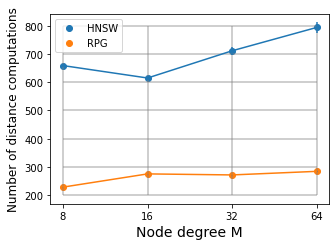

In [12]:
plot_evals_for_recall(results, hlines=np.linspace(200, 800, 7), file_name="pic/synthetic_with_shifted_queries.pdf")